In [2]:
import tensorflow
from Net import Net
import matplotlib.pyplot as plt
import numpy as np
import cv2
import SimpleITK as sitk
import os
from utils import *


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
net = Net('model/stable_10_07_20')


In [3]:
net.process_directory('images/')

file images//121.tif already processed
file images//122.tif already processed


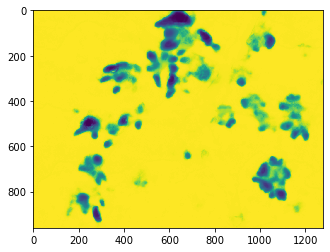

In [4]:
mask = net.find_objects('images/121.tif')
plt.imshow(mask)
contours = net.process_mask(mask)
net.make_json(contours)

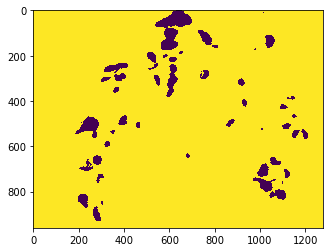

In [5]:
plt.imshow(np.round(mask))

In [3]:
LAB_DIR = 'laborotory_images'
images = os.listdir(LAB_DIR)[:4]


16 bit values: 5238 - 5562
16 bit values: 6137 - 6635
16 bit values: 6237 - 7468
16 bit values: 6095 - 6951


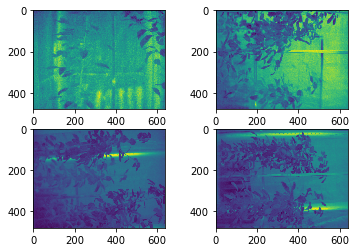

In [7]:
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    print(f'16 bit values: {np.min(img)} - {np.max(img)}')

16 bit values: 0 - 65535
16 bit values: 0 - 65535
16 bit values: 0 - 65535
16 bit values: 0 - 65535


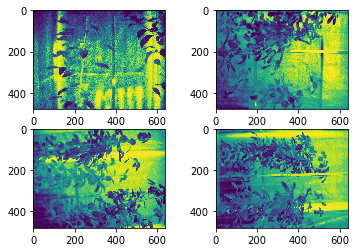

In [8]:
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = change_hist(img)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    print(f'16 bit values: {np.min(img)} - {np.max(img)}')

8 bit values: 0 - 255
8 bit values: 0 - 255
8 bit values: 0 - 255
8 bit values: 0 - 255


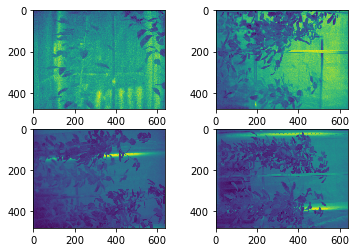

In [9]:
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = change_hist_v2(img, bits=8)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    print(f'8 bit values: {np.min(img)} - {np.max(img)}')

16 bit values: 0 - 65534
16 bit values: 0 - 65534
16 bit values: 0 - 65535
16 bit values: 0 - 65534


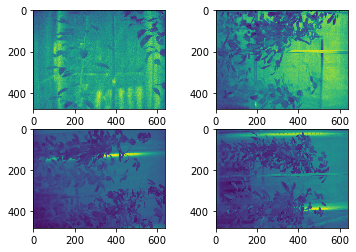

In [10]:
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = change_hist_v2(img, bits=16)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    print(f'16 bit values: {np.min(img)} - {np.max(img)}')

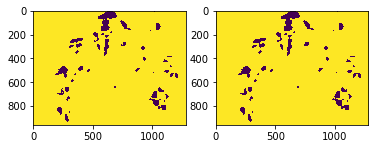

In [11]:
new_mask = erode_dilate(np.round(mask), mask_size=(5,5), iter=2)
plt.subplot(1, 2, 1)
plt.imshow(np.round(mask))
plt.subplot(1, 2, 2)
plt.imshow(new_mask)

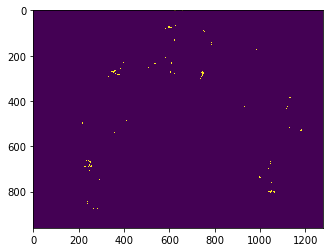

In [12]:
plt.imshow(np.round(mask) - new_mask)

8 bit values: 0 - 255
8 bit values: 0 - 255
8 bit values: 0 - 255
8 bit values: 0 - 255


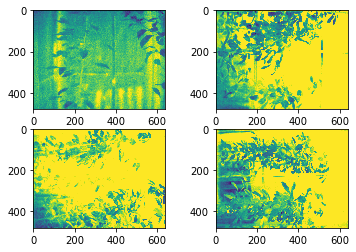

In [4]:
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = simple_segmentation(img)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    cv2.imwrite(f'results/mask{i}.png', img.astype('uint8'))
    print(f'8 bit values: {np.min(img)} - {np.max(img)}')

8 bit values: 0 - 255
8 bit values: 0 - 255
8 bit values: 0 - 255
8 bit values: 0 - 255


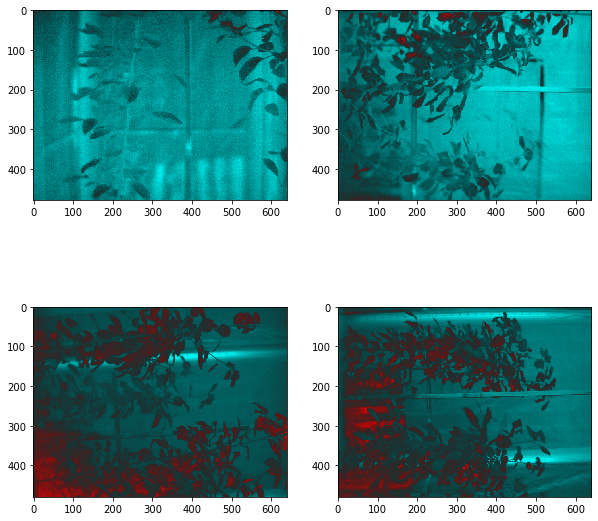

In [5]:
plt.figure(figsize=(10,10))
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = change_hist_v2(img, bits=8)
    mask = simple_segmentation(img)
    img = mask_applying(img, mask, bits=8, depth=10)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    cv2.imwrite(f'results/img{i}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f'8 bit values: {np.min(img)} - {np.max(img)}')

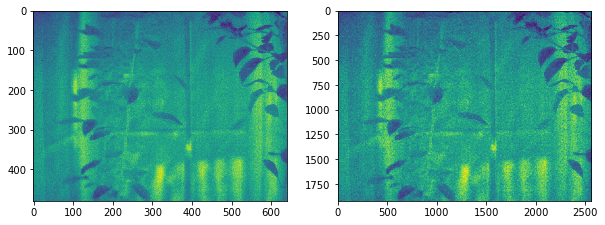

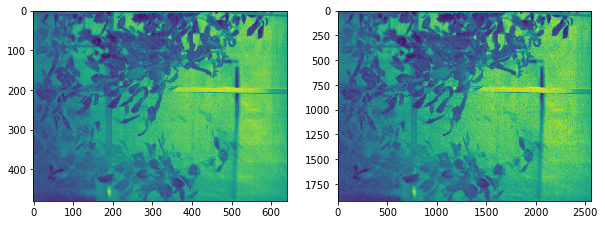

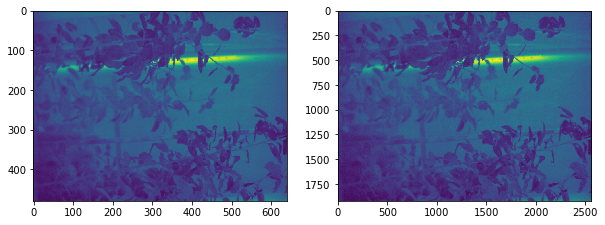

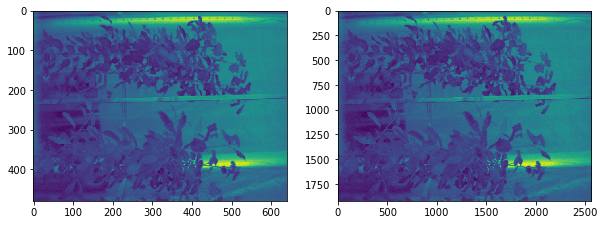

In [15]:
for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = change_hist_v2(img)
    lr = np.zeros((img.shape[0], img.shape[1], 3), dtype=img.dtype)
    lr[:, :, 0] = img
    lr[:, :, 1] = img
    lr[:, :, 2] = img

    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(lr[..., 1])

    sr = super_resolution_x4(lr)
    plt.subplot(1, 2, 2)
    plt.imshow(sr[..., 1])


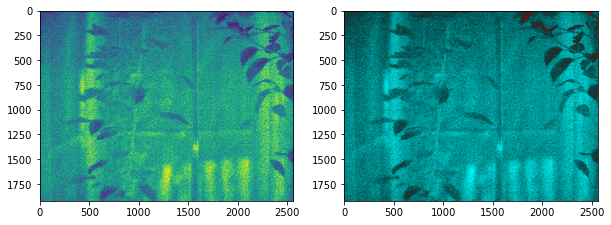

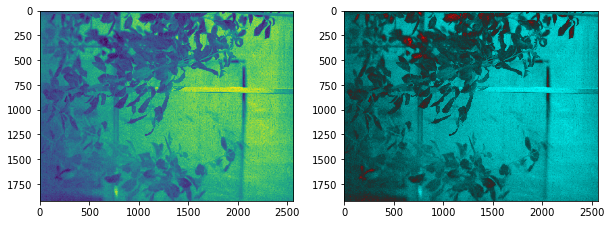

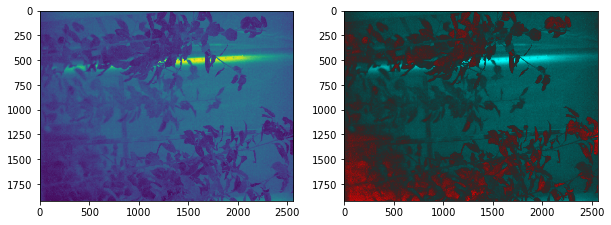

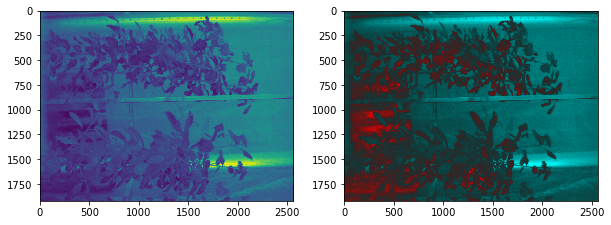

In [6]:

for (i, im_name) in enumerate(images):
    img = cv2.imread(os.path.join(LAB_DIR, im_name), -1)
    img = change_hist_v2(img)
    lr = np.zeros((img.shape[0], img.shape[1], 3), dtype=img.dtype)
    lr[:, :, 0] = img
    lr[:, :, 1] = img
    lr[:, :, 2] = img

    sr = super_resolution_x4(lr)[..., 1]
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(sr)

    mask = simple_segmentation(sr)
    img2 = mask_applying(sr, mask, depth=10)
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    
    cv2.imwrite(f'results/img_sr{i}.png', cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
